In [1]:
dataset <- "Dext3r" # Dext3r has all the series. They should be integrated, however
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Emilia-Romagna"
match_dist <- 10000
new_dataset <- "ER"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = units::set_units(10, "km")) |>
    st_drop_geometry() |>
    filter(
        !state %in% c("Piemonte", "Lombardia", "Toscana", "Veneto", "Marche", "Liguria", "Umbria") | is.na(state),
        network != "DPC",
        dataset != "SCIA" |
            network %in% c("Sinottica", "Mareografica") |
            (dataset == "SCIA" & sensor_key %in% c(3183L, 3135L, 3116L)) # ??
    )
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(1388L, 678L, 2114L, 2708L, 2906L, 349L))) # Ferrara, Casalecchio, Modena, Parma, Punta Marina, Bologna Synop
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db)
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
# analysis <- read_parquet(file.path("notebooks", "ds_regionali", "emilia-romagna", "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("series_id"), starts_with("tag_"))


In [6]:
source("src/merging/combining.R")
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 10, 0L, merging_datasets, desc(dataset), desc(sensor_last))
merged_checkpoint(new_dataset, saved_to, metadata)


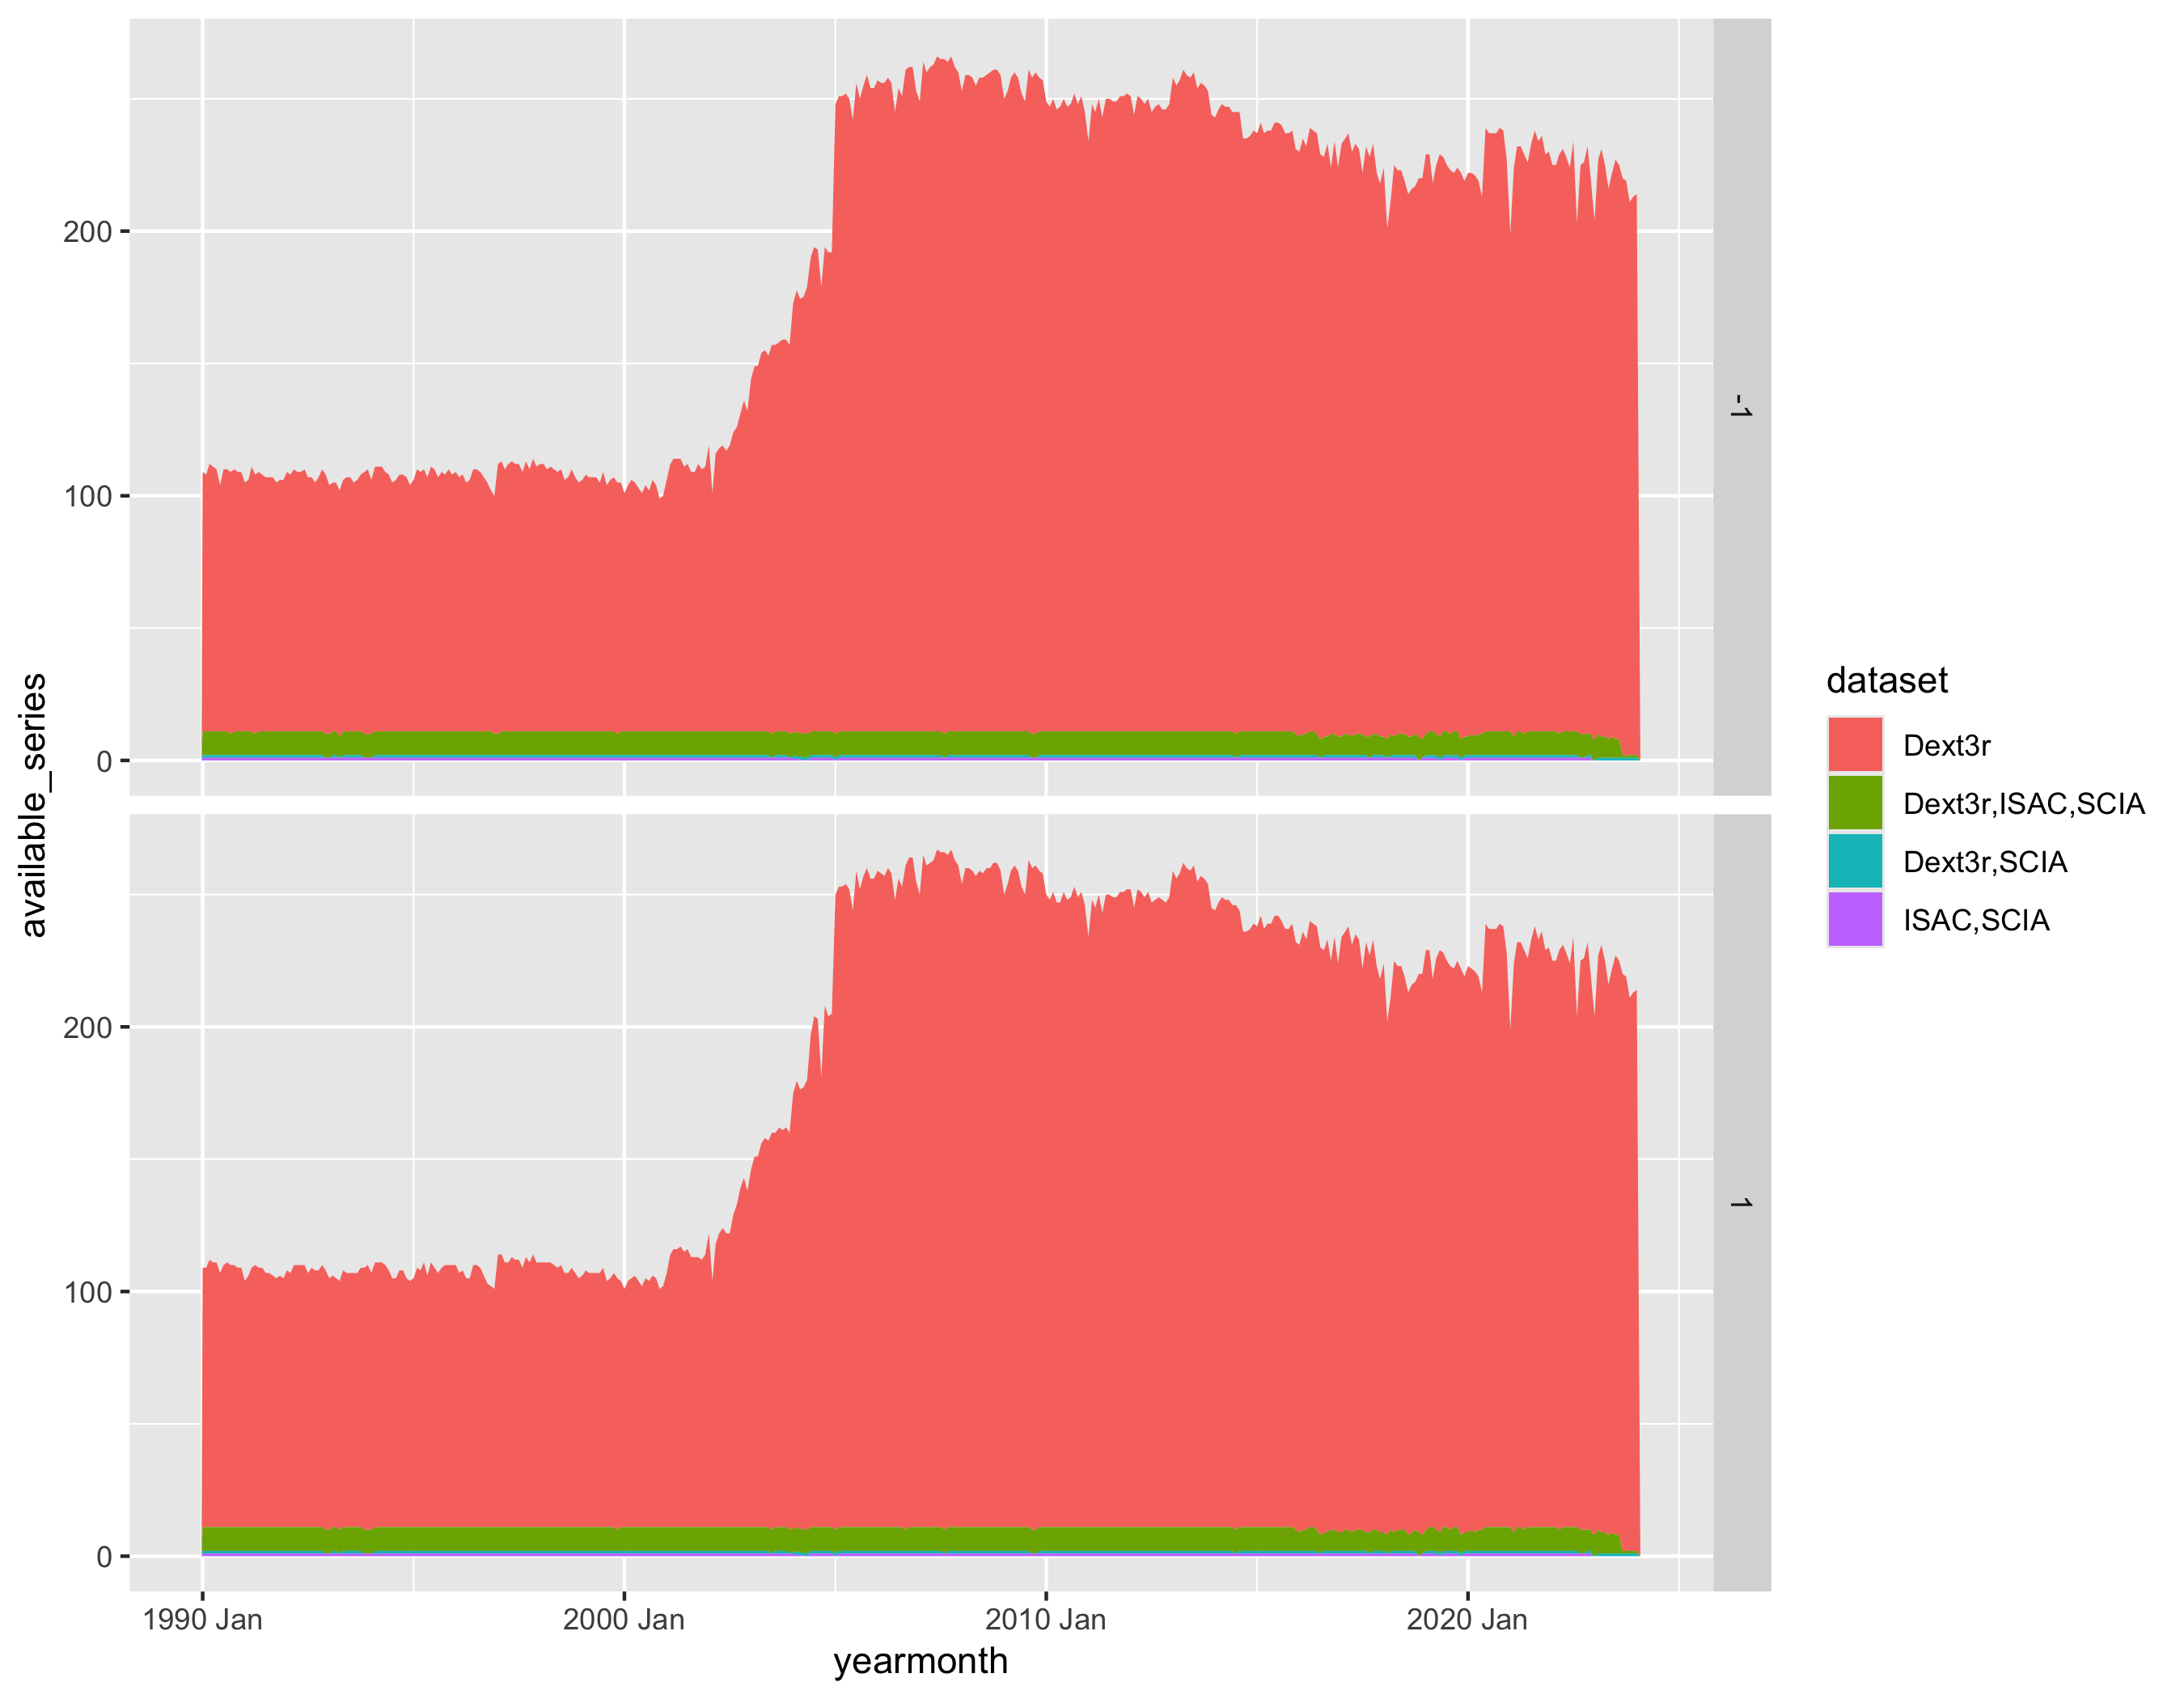

In [7]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = T)
pd$plot + facet_grid(variable ~ .)


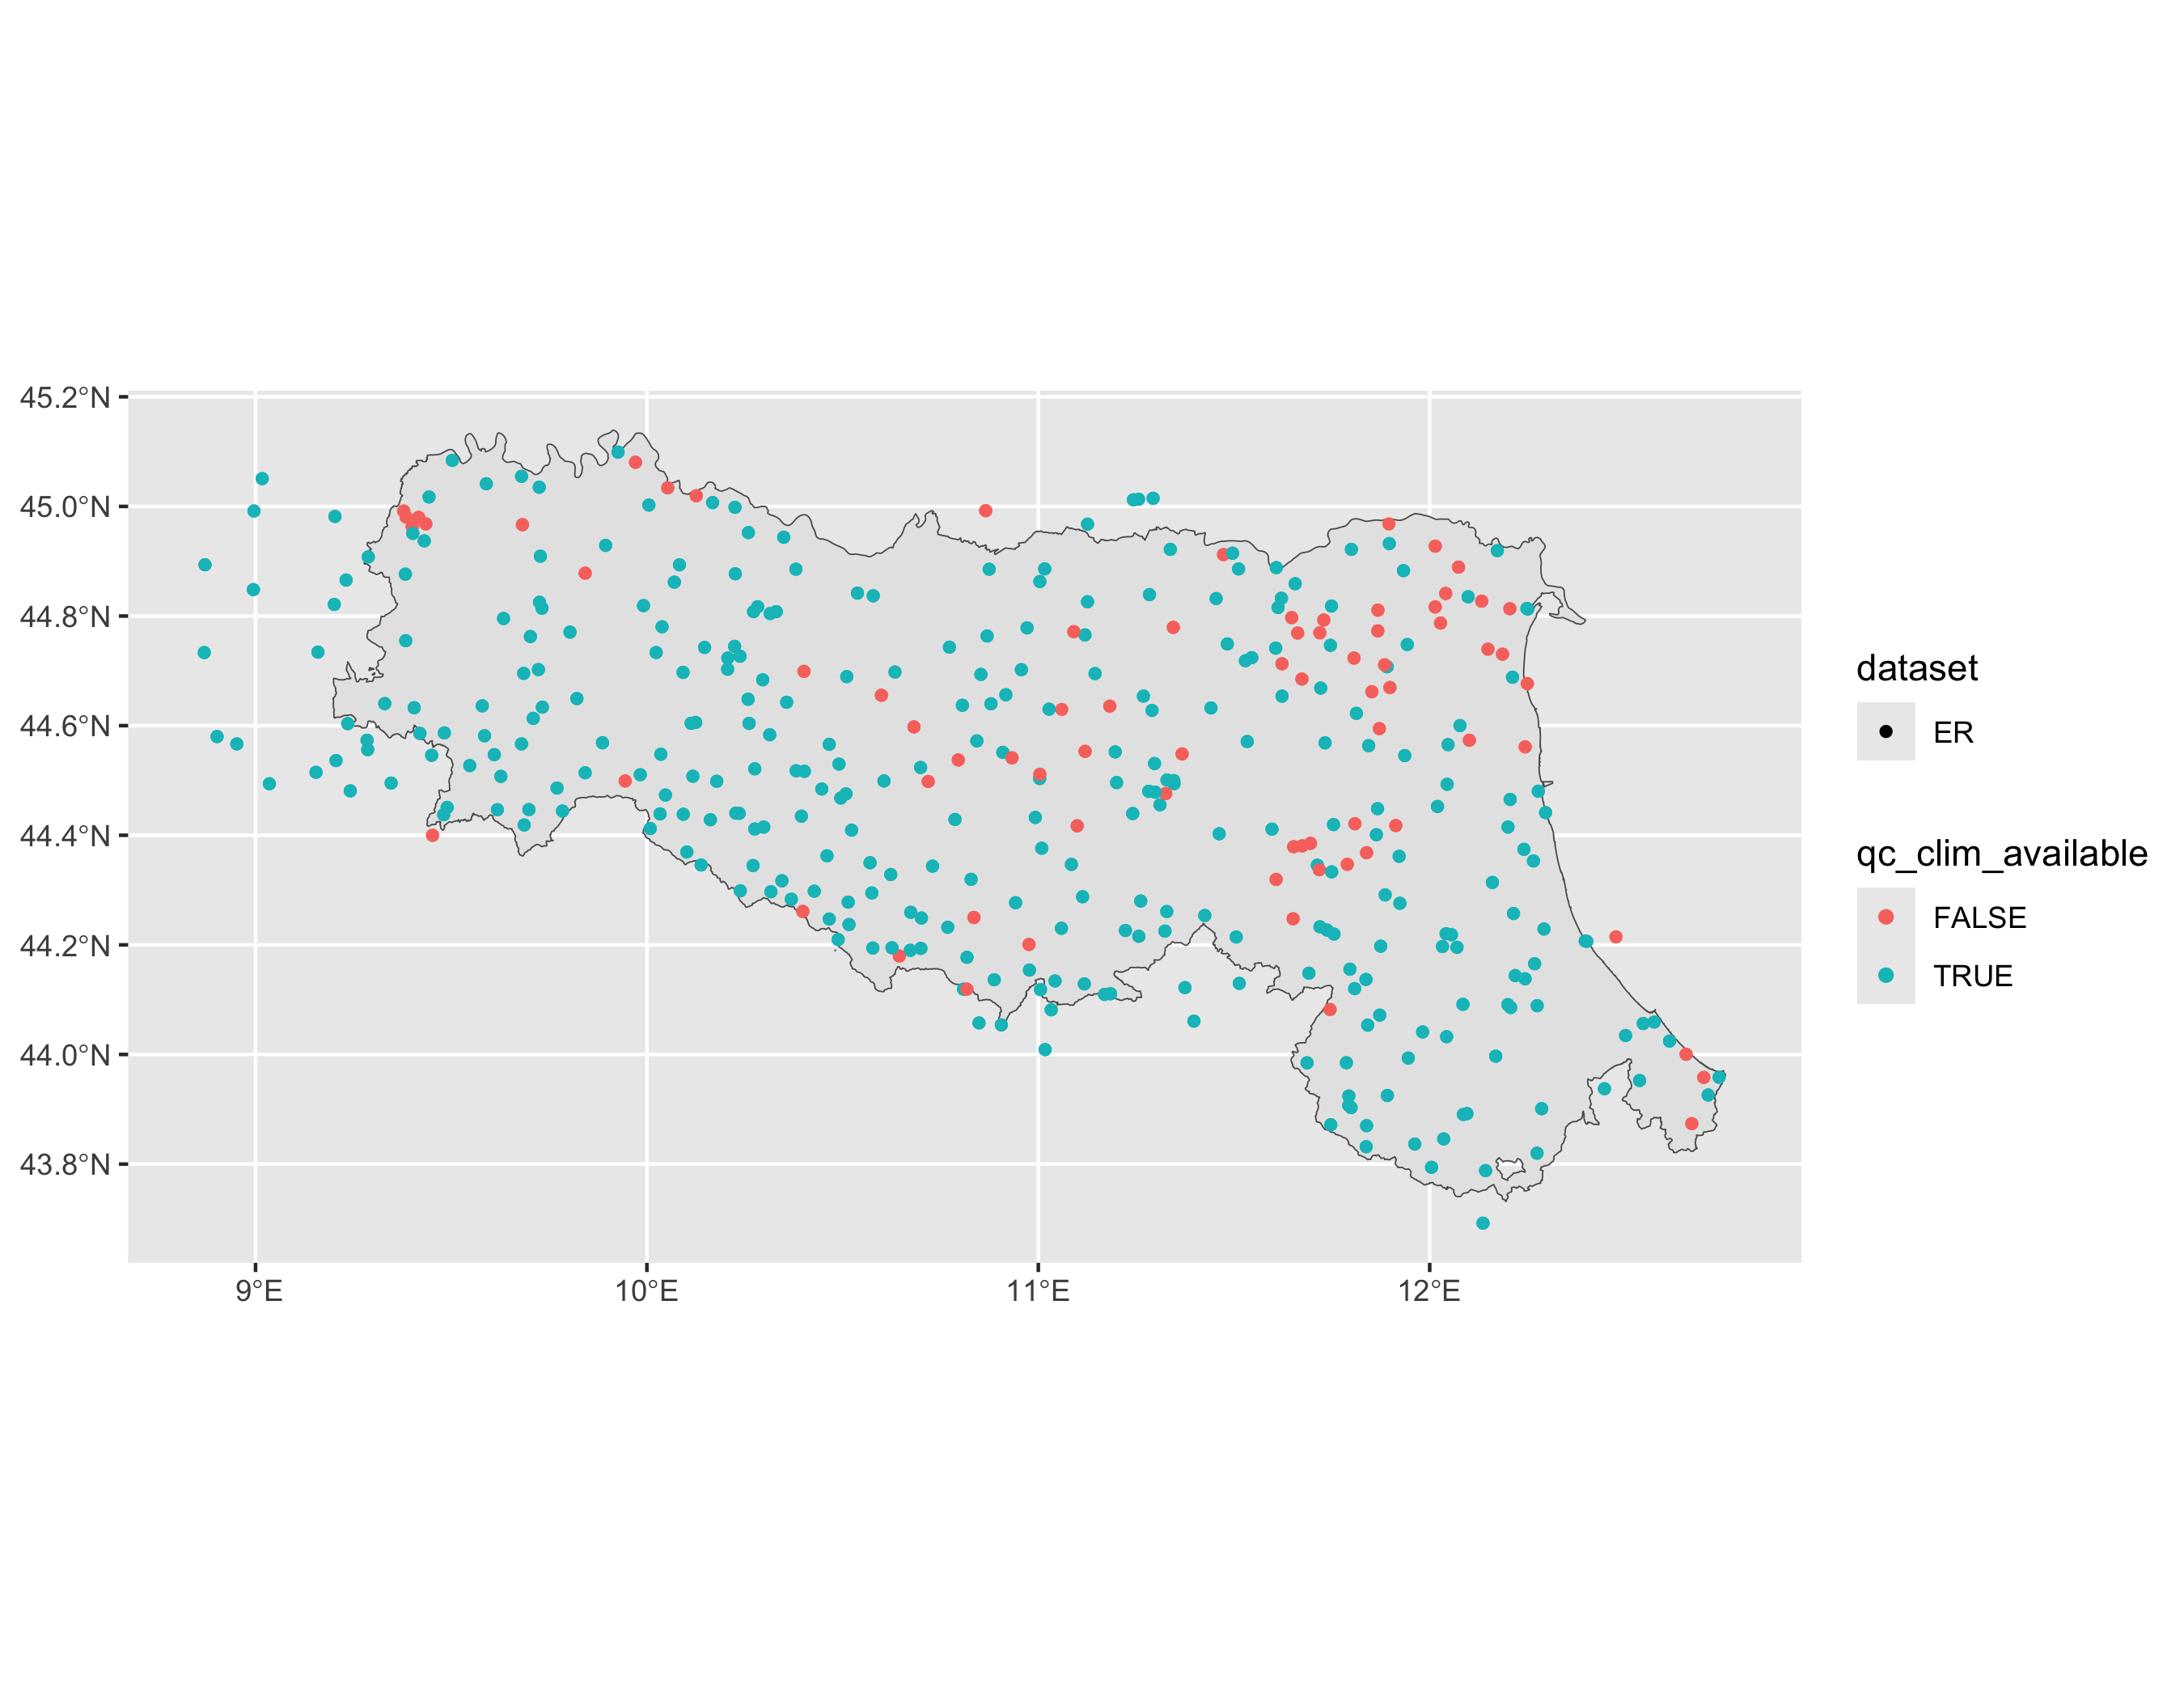

In [8]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


In [9]:
merge_specs <- read_parquet(str_glue("db/extra/merge_specs/{new_dataset}.parquet")) |>
    mutate(km = k0 + 2 * k1 / pi)
merge_specs |>
    filter(abs(km) > 0.5) |>
    arrange(desc(abs(km))) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    relocate(km, name)


km,name,set,gkey,variable,metadata_rank,data_rank,skip_correction,dataset,sensor_key,k0,k1,k2,k3,merged,offset
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
-2.2278095,Ferrara,ER,78,-1,3,3,FALSE,Dext3r,560,-1.65125764,-0.9056455,0.07836848,-0.004327885,TRUE,0
2.2209512,Novafeltria,ER,135,-1,2,2,FALSE,Dext3r,996,1.85399401,0.5764151,0.05656850,-0.075722643,TRUE,0
-1.7076023,Verghereto,ER,209,1,2,2,FALSE,Dext3r,1678,-1.70760234,0.0000000,0.00000000,0.000000000,TRUE,0
-1.6100760,Ferrara,ER,78,1,3,3,FALSE,Dext3r,560,-1.52567988,-0.1325691,-0.07193690,-0.064701055,TRUE,-1
-1.5088924,Malborghetto di Boara,ER,108,-1,2,2,FALSE,Dext3r,807,-1.02679616,-0.7572750,-0.09951348,-0.073880431,TRUE,0
-1.3899203,Imola,ER,94,1,3,3,FALSE,Dext3r,696,-0.61766088,-1.2130622,0.09558534,-0.190942569,TRUE,-1
-1.2924567,diga del Brasimone,ER,68,1,2,2,FALSE,Dext3r,1743,-1.02903862,-0.4137761,-0.17394704,0.098966862,TRUE,0
1.1867133,Bologna meteo,ER,21,1,3,3,FALSE,Dext3r,134,1.18671329,0.0000000,0.00000000,0.000000000,TRUE,0
-1.1407495,Rimini,ER,165,-1,3,3,FALSE,Dext3r,1294,-3.17152601,3.1899363,0.45695922,0.380640627,TRUE,0


In [11]:
merge_specs |>
    filter(gkey == 78L) |>
    select(dataset, sensor_key, variable, data_rank, metadata_rank, km, k0, k1) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key"))


dataset,sensor_key,variable,data_rank,metadata_rank,km,k0,k1,name
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Dext3r,562,-1,1,1,0.0000000,0.00000000,0.00000000,Ferrara urbana
Dext3r,561,-1,2,2,-0.0412380,-0.05581763,0.02290163,Ferrara Urbana
Dext3r,560,-1,3,3,-2.2278095,-1.65125764,-0.90564554,Ferrara
Dext3r,562,1,1,1,0.0000000,0.00000000,0.00000000,Ferrara urbana
Dext3r,561,1,2,2,0.1067301,-0.01092298,0.18480898,Ferrara Urbana
Dext3r,560,1,3,3,-1.6100760,-1.52567988,-0.13256911,Ferrara


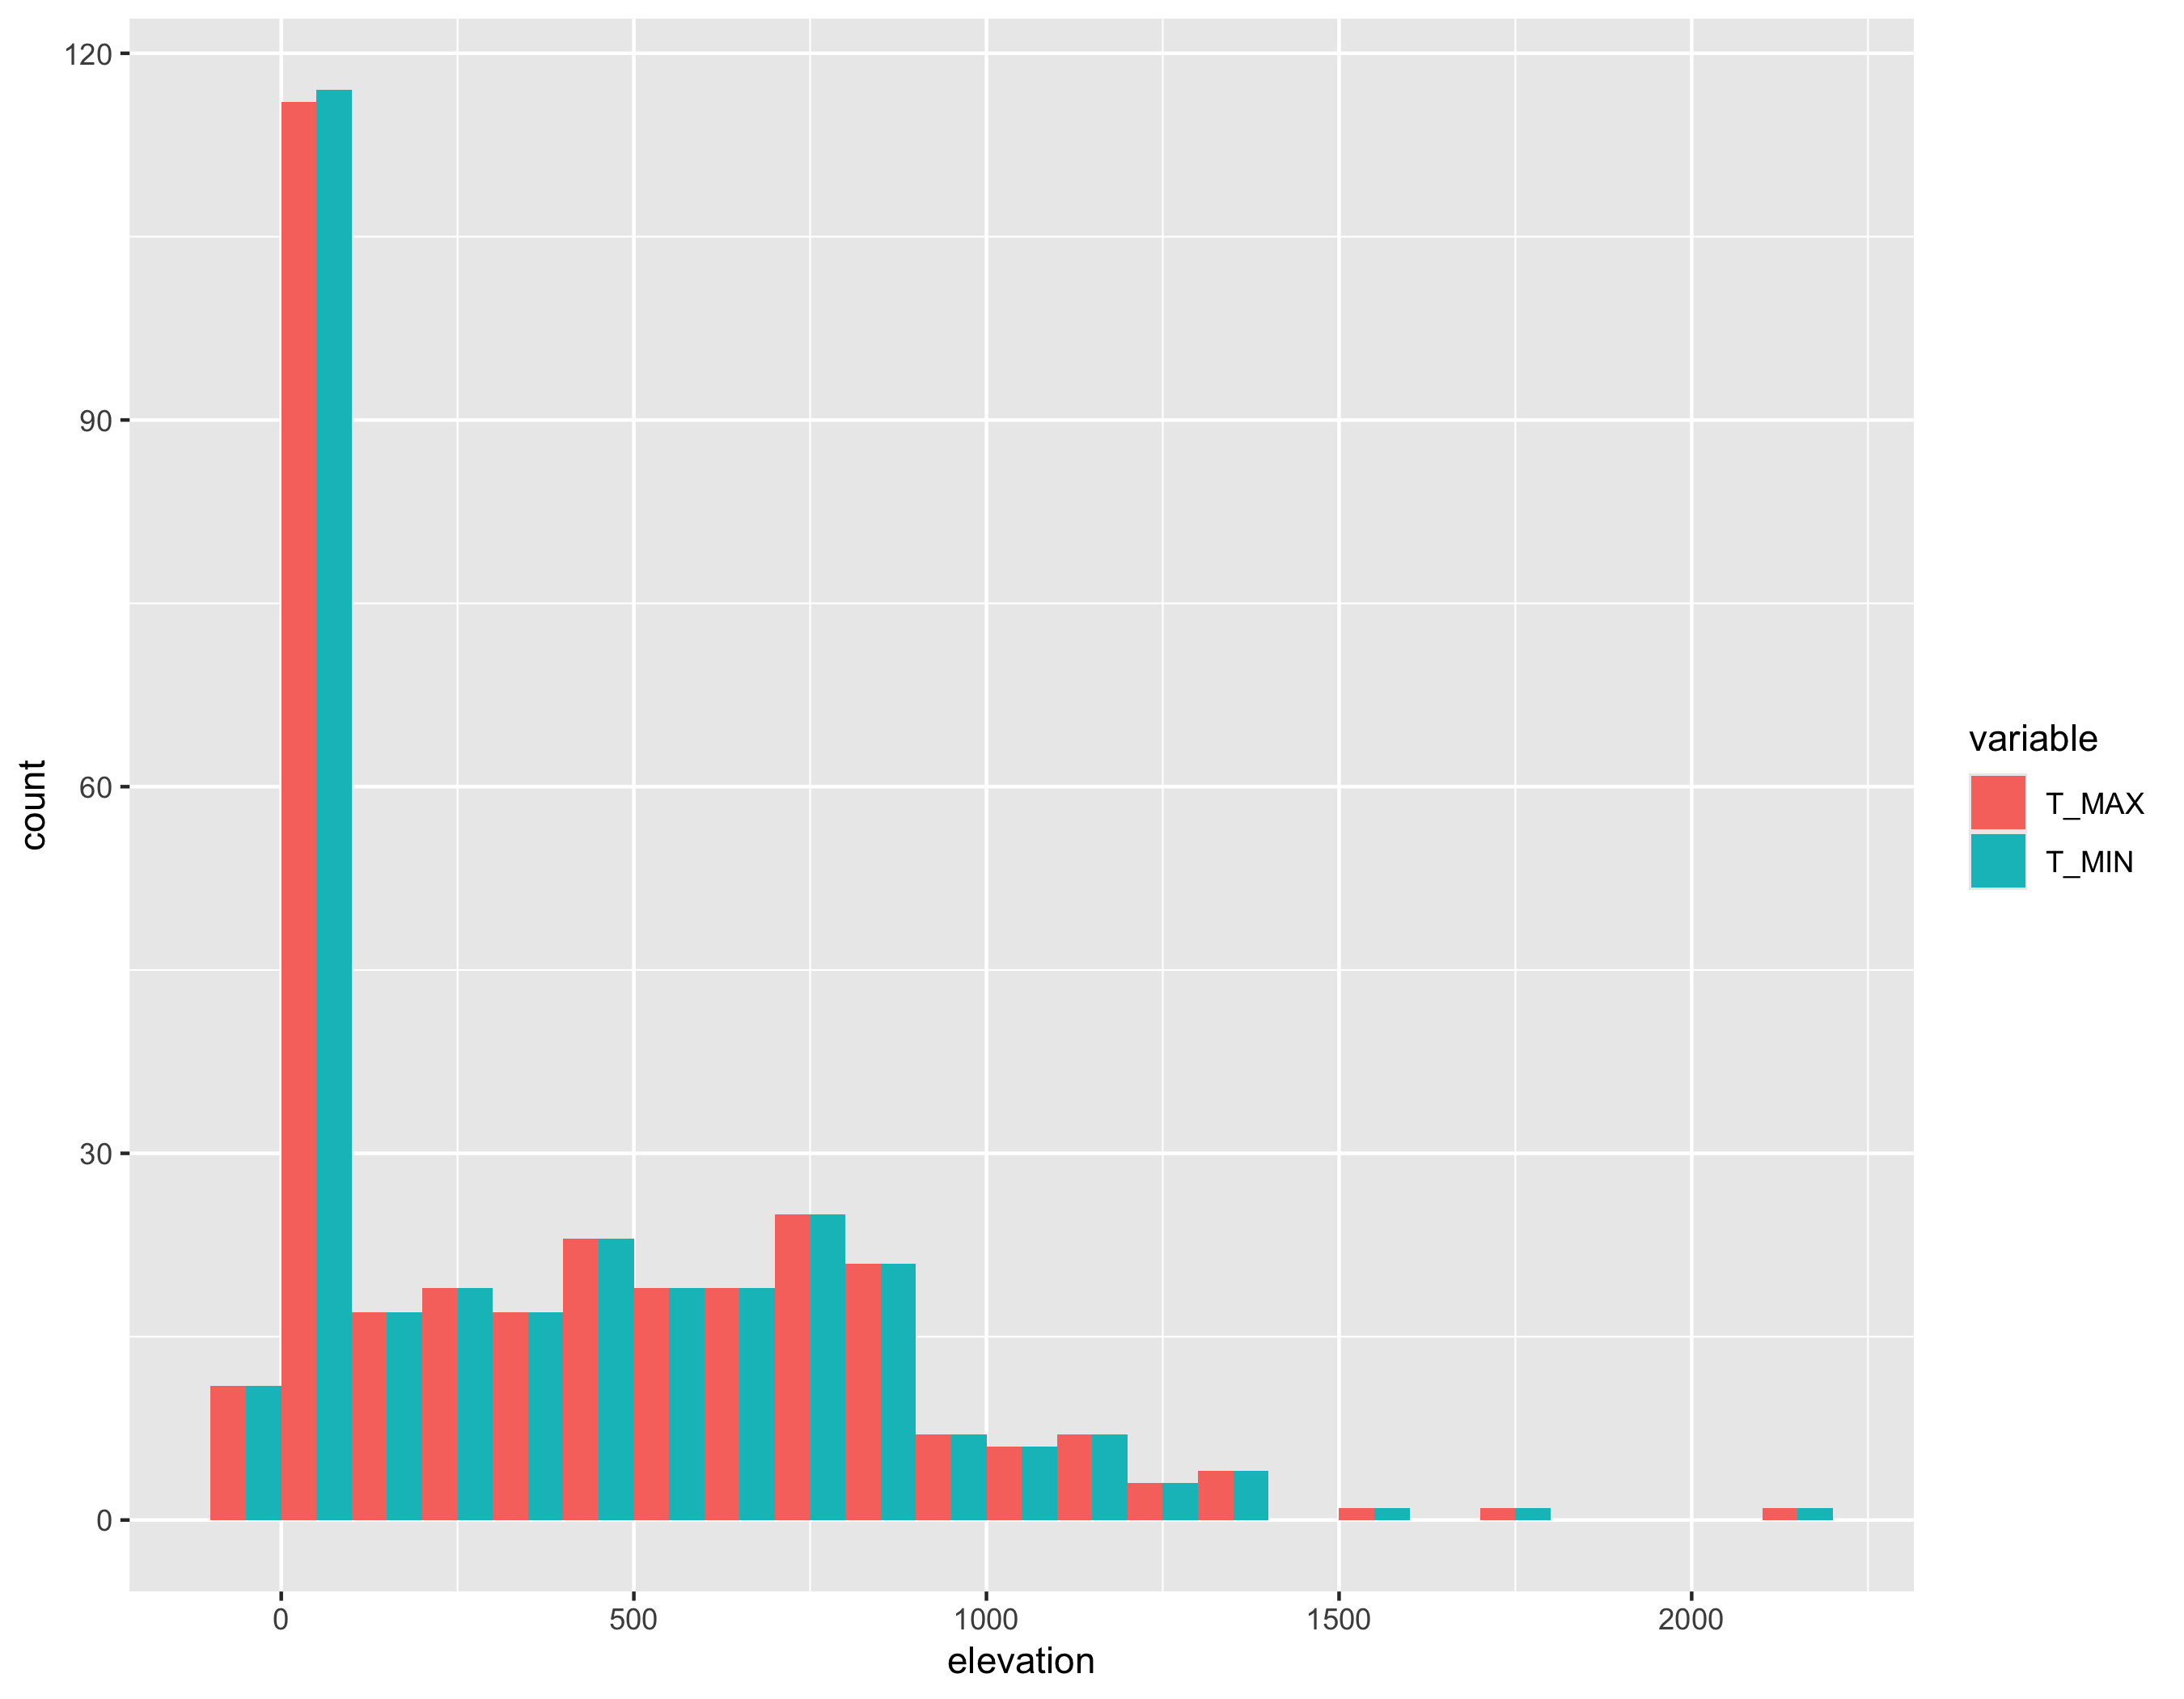

In [12]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())
